# Product Propensity - Default Features
* StelllarAlgo Data Science
* Ryan Kazmerik, Nakisa Rad, Joey Lai
* Jul 6, 2022

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pycaret.classification import *

## Step 1 : Generate Datasets

### Let's convert our training dataset into a dataframe and check the shape:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMlsinterMiami].[ds].[getProductPropensityModelData_staging2] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["seasonYear"] = pd.to_numeric(df["seasonYear"])

CNXN.commit()
cursor.close()

df.shape

(29333, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29333 entries, 0 to 29332
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  29333 non-null  int64  
 1   distance             29333 non-null  float64
 2   seasonYear           29333 non-null  int64  
 3   events_prior         29333 non-null  int64  
 4   attended_prior       29333 non-null  int64  
 5   events_last          29333 non-null  int64  
 6   attended_last        29333 non-null  int64  
 7   tenure               29333 non-null  int64  
 8   atp_last             29333 non-null  float64
 9   product_current      29333 non-null  object 
 10  product_last         29333 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 2.5+ MB


In [5]:
df.head()

,dimCustomerMasterId,distance,seasonYear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last
0,7,62.69,2023,1,1,1,1,0,33.0,None,Individual
1,24,10.70,2023,1,0,1,0,0,80.0,None,Individual
2,28,70.42,2022,1,0,1,0,0,32.0,None,Individual
3,28,70.42,2023,1,0,0,0,1,0.0,None,None
4,36,82.62,2022,1,1,1,1,0,85.0,None,Individual


### Let's specify the features we would like to use to train our model:

In [6]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (24933, 11)
Unseen Data For Predictions: (4400, 11)



## Step 2: Create Model

### Now we can model the data using a multiclass classifier to predict probabilities that a fan will purchase each product offered by the team:

In [7]:
setup(
    data= df_train, 
    target="product_current", 
    train_size = 0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=[
        "dimCustomerMasterId",
        "seasonYear"
    ],
    numeric_features=[
        "atp_last",
        "attended_last",
        "attended_prior",
        "events_last",
        "events_prior",
        "distance",
        "tenure" 
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [8]:
model_matrix = compare_models(
    fold= 10,
    include= ["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9075,0.5661,0.4749,0.9072,0.9071,0.6726,0.6729,0.5880


### Let's grab the model and finalize it over 10-fold validation:

In [9]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9118,0.9503,0.4451,0.9108,0.9111,0.6874,0.6875
1,0.9042,0.9342,0.4223,0.9016,0.9022,0.6552,0.6557
2,0.9104,0.9572,0.4452,0.9101,0.9101,0.6832,0.6834
3,0.9033,0.0000,0.4215,0.9004,0.9017,0.6512,0.6513
4,0.9070,0.0000,0.5547,0.9090,0.9080,0.6750,0.6752
5,0.9042,0.0000,0.5496,0.9053,0.9046,0.6653,0.6655
6,0.9042,0.0000,0.5717,0.9104,0.9069,0.6756,0.6768
7,0.9155,0.9544,0.4531,0.9127,0.9141,0.6970,0.6971
8,0.9089,0.9342,0.4475,0.9080,0.9079,0.6739,0.6742
9,0.9051,0.9308,0.4380,0.9036,0.9041,0.6622,0.6624


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Step 3 : Evaluate Model

### The correlation matrix shows us attributes that are statistically correlated with the target variable:

### We can have a look at the most important features that determine a correct prediction by the model:

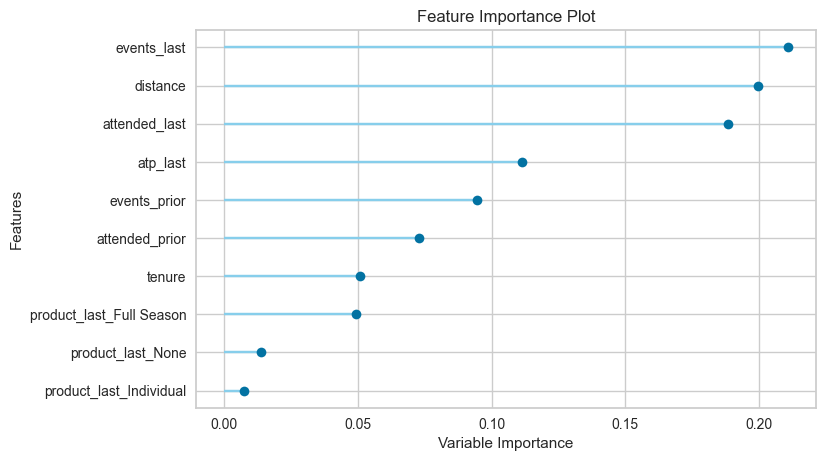

In [10]:
plot_model(final_model, plot='feature')

### Let's also look at the confusion matrix for hits and misses:

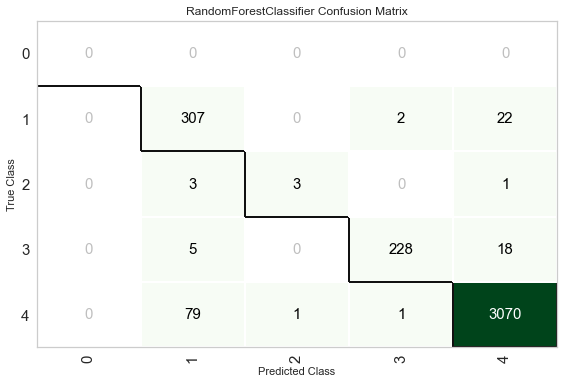

In [11]:
plot_model(final_model, plot="confusion_matrix")

### Let's save our model for future use:

### Let's load in our 2022 season data and get product propensity probabilities using the model:

In [12]:
df_inference = df.loc[df["seasonYear"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(26054, 11)

In [13]:
df_predictions = predict_model(final_model, data=df_inference)
df_predictions.head()

,dimCustomerMasterId,distance,seasonYear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last,Label,Score
0,7,62.69,2023,1,1,1,1,0,33.0,None,Individual,None,1.00
1,24,10.70,2023,1,0,1,0,0,80.0,None,Individual,None,1.00
2,28,70.42,2022,1,0,1,0,0,32.0,None,Individual,None,1.00
3,28,70.42,2023,1,0,0,0,1,0.0,None,None,None,1.00
4,36,82.62,2022,1,1,1,1,0,85.0,None,Individual,None,0.99


### Now we can see the count for each products in the inference data:

In [14]:
counts = df_predictions.Label.value_counts()
counts

None           23601
Individual      1738
Full Season      696
Half Season       13
Flex Plan          6
Name: Label, dtype: int64

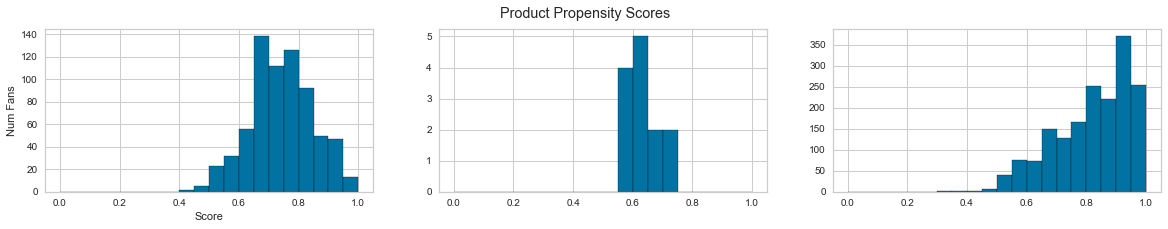

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

fig.suptitle("Product Propensity Scores")

ax1.hist(df_predictions[df_predictions.Label == "Full Season"].Score, bins=20,  edgecolor="black", range=(0,1))
ax2.hist(df_predictions[df_predictions.Label == "Half Season"].Score, bins=20, edgecolor="black", range=(0,1))
ax3.hist(df_predictions[df_predictions.Label == "Individual"].Score, bins=20, edgecolor="black", range=(0,1))

ax1.set_xlabel('Score')
ax1.set_ylabel('Num Fans')

plt.show()

In [16]:
df_predictions_fs = df_predictions[df_predictions.Label == "Full Season"]

df_predictions_fs_new = df_predictions_fs[df_predictions_fs.product_last != "Full Season"]

df_predictions_fs_new.shape

(22, 13)

### Let's export these scores to csv for further analysis:

In [17]:
df_predictions.to_csv("./results/InterMiami_ProductPropensity_Scores_2022-07-18.csv")

### Done